In [ ]:
import os
import pickle
from typing import Callable

import numpy as np
from numba import njit

from matplotlib import pyplot as plt

from utils.core import(
    bound_critical_parameter,
    locate_critical_parameter,
    bruteforce_parameter_and_energy_relationship,
)

from utils.plot import draw_horizons, blend_color
from utils.utilities import geospace
import utils.plot as plot_utils

In [20]:
forced = True  # if True, the code will always run the brute-force search and save results to a file, otherwise it will load the results from a file

In [ ]:
### SPECIFY PARAMETERS

# Runge-Kutta parameters
R_MIN = 1.0
R_MAX = 1000.0
STEP = -0.05

# secant method parameters
SECANT_TOLERANCE = 1e-8
SECANT_MAX_ITERS = 50
SECANT_INITIAL_STEP = 1e-6


# critical parameter in the parameter space

MAX_ITERS = 20
ALPHA_MAX = 300 # ad hoc, could be arbirtrarily large
ALPHA_MIN = 0

# locate critical parameter value using binary search

BISECTION_TOLERANCE = 1e-11
BISECTION_MAX_ITERS = 20
BISECTION_ROOT_TOLERANCE = 1e-3

# brutefore parameter range setup
COUNT = 100
OFFSET = 50
RATIO = 0.9

# Density profile

shell = "bump"

RADIUS = 500
WIDTH = 100

def get_rho(parameter: float) -> Callable[[float], float]:

    amplitude = parameter
    radius = RADIUS
    width = WIDTH
    @njit
    def _rho(x: float) -> float:
        # return amplitude if np.abs(x - radius) <= 0.5 * width else 0.0
            return amplitude * np.exp(1.0 / ((x - radius) ** 2 - (0.5 * width)**2)) if np.abs(x - radius) < 0.5 * width else 0.0
    return _rho

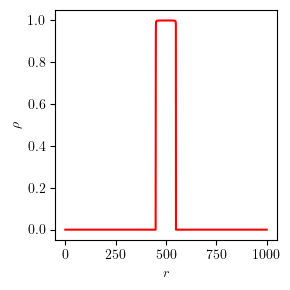

In [36]:
# plot the density profile

unit_rho = get_rho(1)
r_vals = np.arange(R_MAX, R_MIN + STEP, STEP)
unit_rho_vals = [unit_rho(_r) for _r in r_vals]\

plt.figure(figsize=(3, 3))
plt.xlabel(r"$r$")
plt.ylabel(r"$\rho$")
plt.plot(r_vals, unit_rho_vals, color="red")
plt.tight_layout()
plt.show()

In [25]:
if not forced and (os.path.isfile("data/" +  shell + "_critical.pkl")):
    with open("data/" +  shell + "_critical.pkl", "rb") as f:
        results = pickle.load(f)

    critical_alpha = results["critical_alpha"]
    critical_parameter = results["critical_parameter"]

else:
    ((parameter_lower, parameter_upper), (alpha_lower, alpha_upper), boolean_success) = bound_critical_parameter(
        _get_rho = get_rho,
        rk_start = R_MAX,
        rk_end = R_MIN,
        rk_step = STEP,
        secant_tolerance = SECANT_TOLERANCE,
        secant_max_iters = SECANT_MAX_ITERS,
        secant_initial_step = SECANT_INITIAL_STEP,
        parameter_max = None,
        alpha_max = ALPHA_MAX,
        alpha_min = ALPHA_MIN,
        max_iters = MAX_ITERS,
        minimal_seeked_bound_distance = 1e-3,
        verbose = True,
        scale = 2,
    )

    critical_alpha, critical_parameter, _ = locate_critical_parameter(
        _get_rho = get_rho,
        start = parameter_lower,
        end = parameter_upper,
        alpha_start = alpha_lower,
        alpha_end = alpha_upper,
        rk_start = R_MAX,
        rk_end = R_MIN,
        rk_step = STEP,
        secant_tolerance = SECANT_TOLERANCE,
        secant_max_iters = SECANT_MAX_ITERS,
        secant_initial_step = SECANT_INITIAL_STEP,
        bisection_tolerance = BISECTION_TOLERANCE,
        bisection_max_iters = BISECTION_MAX_ITERS,
        bisection_root_tol = BISECTION_ROOT_TOLERANCE
    )

    with open("data/" +  shell + "_critical.pkl", "wb") as f:
        pickle.dump(
            {
                "critical_alpha": critical_alpha,
                "critical_parameter": critical_parameter,
            },
            f,
    )
    

Upper bound for amplitude is approximately: 1.0417749627299166e-06 

[0] 1.04e-06 at least one secant did not converge.
[1] 5.21e-07 at least one secant did not converge.
[2] 2.60e-07 converged! 

 top: 172.99311858 after 8 secant iterations
 bot: 95.10686666 after 7 secant iterations

Found bounds for critical parameter and alpha values:
Alpha bounds: 95.10686666095093 172.99311858133913
Parameter bounds: 2.6044374068247915e-07 5.208874813649583e-07
[0] (2.60e-07  | 3.91e-07 | 5.21e-07) <<< []
[1] (2.60e-07  | 3.26e-07 | 3.91e-07) <<< []
[2] (2.60e-07  | 2.93e-07 | 3.26e-07) <<< []
[3] (2.60e-07  | 2.77e-07 | 2.93e-07) <<< []
[4] (2.60e-07  | 2.69e-07 | 2.77e-07) ↑ ↓ >>> [115.68254731300156, 144.43890586333532]
[5] (2.69e-07  | 2.73e-07 | 2.77e-07) <<< []
[6] (2.69e-07  | 2.71e-07 | 2.73e-07) <<< []
[7] (2.69e-07  | 2.70e-07 | 2.71e-07) ↑ ↓ >>> [122.62494918530703, 136.51993711900454]
[8] (2.70e-07  | 2.70e-07 | 2.71e-07) <<< []
[9] (2.70e-07  | 2.70e-07 | 2.70e-07) ↑ ↓ >>> [126.47944

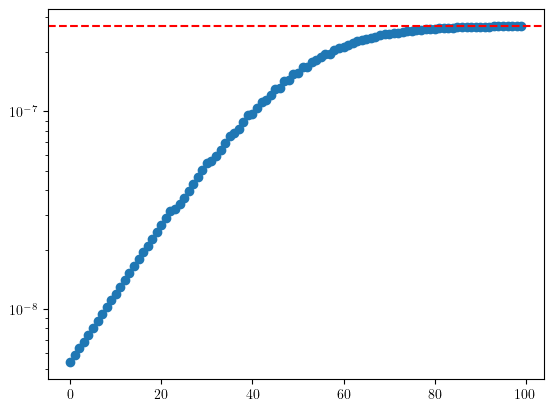

In [26]:
geometric = geospace(critical_parameter / OFFSET, critical_parameter, steps = (COUNT // 2)+1, ratio=RATIO)
logarithmic = np.logspace(np.log10(critical_parameter / OFFSET), np.log10(critical_parameter), COUNT // 2, base=10.0)
parameters = np.sort(np.concatenate((geometric, logarithmic)))[1:] # join, sort and remove first duplicit value

plt.scatter(range(len(parameters)), parameters)
plt.axhline(critical_parameter, color="red", linestyle="--", label="critical parameter")
plt.yscale("log")
plt.show()

In [27]:
# ∇ Ψ + 2πρ Ψ^exponent = 0
exponent = 5 # for scaling
parameter_search_range = parameters.copy()
alpha_search_range = np.linspace(0, 2000, 10) # starting guesses, ad hoc, could be arbirtrarily large

In [28]:
if not forced and (os.path.isfile("data/" +  shell + "_results.pkl")):
    with open("data/" +  shell + "_results.pkl", "rb") as f:
        results = pickle.load(f)

    ADM_mass_vals = results["E_ADM"]
    rest_mass_vals = results["rest_mass"]
    parameters = results["parameters"]
    horizons = results["horizons"]

else:

    ADM_mass_vals, rest_mass_vals, parameters, horizons = bruteforce_parameter_and_energy_relationship(
        get_rho,
        parameter_search_range,
        alpha_search_range,
        (R_MAX, R_MIN, STEP),
        (SECANT_TOLERANCE, SECANT_MAX_ITERS, SECANT_INITIAL_STEP),
        exponent = exponent,
        unique_root_tolerance=1e-4,
    )

    with open("data/" +  shell + "_results.pkl", "wb") as f:
        pickle.dump(
            {
                "E_ADM": ADM_mass_vals,
                "rest_mass": rest_mass_vals,
                "parameters": parameters,
                "horizons": horizons,
            },
            f,
        )

[1/100] ✓ parameter = 5.398198846335637e-09, (unique tolerance 0.0001), 0 out of 10 attempts failed, found 2 solutions: 
  [1] 0.8562 (err 3.4e-08 %, 5/10, ψ'(0) ≈ 1e-10) rest mass = 1.7, ADM energy = 1.7
  [2] 1898.6771 (err 2.5e-11 %, 5/10, ψ'(0) ≈ -6e-10) rest mass = 1.8e+04, ADM energy = 3.8e+03
   [!] found apparent horizon at roughly around r = 1898.65

[2/100] ✓ parameter = 5.846847079298988e-09, (unique tolerance 0.0001), 0 out of 10 attempts failed, found 2 solutions: 
  [1] 0.928 (err 4.4e-08 %, 6/10, ψ'(0) ≈ 2e-10) rest mass = 1.9, ADM energy = 1.9
  [2] 1847.526 (err 5.1e-11 %, 4/10, ψ'(0) ≈ 1e-09) rest mass = 1.7e+04, ADM energy = 3.7e+03
   [!] found apparent horizon at roughly around r = 1847.5

[3/100] ✓ parameter = 6.332782793266826e-09, (unique tolerance 0.0001), 0 out of 10 attempts failed, found 2 solutions: 
  [1] 1.0058 (err 6.3e-08 %, 6/10, ψ'(0) ≈ 2e-10) rest mass = 2, ADM energy = 2
  [2] 1797.3568 (err 5.7e-11 %, 4/10, ψ'(0) ≈ -1e-09) rest mass = 1.6e+04, ADM 

numerical c. amplitude 2.6990994231678187e-07
numerical c. ADM mass: 258.8482311233783


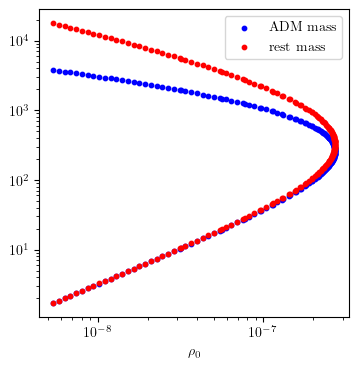

In [32]:
print(f"numerical c. amplitude {critical_parameter}")
print(f"numerical c. ADM mass: {2 * critical_alpha}")

plt.figure(figsize=(4, 4))
plt.scatter(
    parameters,
    ADM_mass_vals,
    label="ADM mass",
    color="blue",
    s=10
)

plt.scatter(
    parameters,
    rest_mass_vals,
    label="rest mass",
    color="red",
    s=10
)

plt.xlabel(r"$\rho_0$")

plt.xscale("log")
plt.yscale("log")
plt.legend()

In [33]:
_parameters = np.array([parameters[i] for i in np.argsort(ADM_mass_vals)])
_rest_mass_vals = np.array([rest_mass_vals[i] for i in np.argsort(ADM_mass_vals)])
_ADM_mass_vals = np.array([ADM_mass_vals[i] for i in np.argsort(ADM_mass_vals)])

critical_index = np.argmin(np.abs(np.array(_parameters) - critical_parameter))

lower_branch_ADM_mass = _ADM_mass_vals[:critical_index + 1]
lower_branch_rest_mass = _rest_mass_vals[:critical_index + 1]
lower_branch_parameters = _parameters[:critical_index + 1]

upper_branch_ADM_mass = _ADM_mass_vals[critical_index:]
upper_branch_rest_mass = _rest_mass_vals[critical_index:]
upper_branch_parameters = _parameters[critical_index:]


horizon_parameters = [val[0] for val in horizons]
horizon_ADM_mass = [val[1] for val in horizons]
horizon_rest_mass = [val[2] for val in horizons]

horizons_start_at_parameter = np.max(horizon_parameters)

# separate those values with horizons and those without

upper_branch_parameters_with_horizons = [par for par in upper_branch_parameters if par <= horizons_start_at_parameter]
upper_branch_ADM_mass_with_horizons = [mass for mass, par in zip(upper_branch_ADM_mass, upper_branch_parameters) if par <= horizons_start_at_parameter]
upper_branch_rest_mass_with_horizons = [mass for mass, par in zip(upper_branch_rest_mass, upper_branch_parameters) if par <= horizons_start_at_parameter]

upper_branch_without_horizons = [par for par in upper_branch_parameters if par >= horizons_start_at_parameter]
upper_branch_ADM_mass_without_horizons = [mass for mass, par in zip(upper_branch_ADM_mass, upper_branch_parameters) if par >= horizons_start_at_parameter]
upper_branch_rest_mass_without_horizons = [mass for mass, par in zip(upper_branch_rest_mass, upper_branch_parameters) if par >= horizons_start_at_parameter]

first horizon found at approx. parameter 8.8e-08 with ADM energy 1.1e+03 and rest mass 2.4e+03


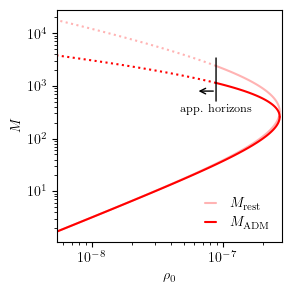

In [34]:
# scale = 0.4
width = 3.02419 #plot_utils.textwidth * scale * plot_utils.cm_to_inch
height = 3.02419 #  width

color = "red"
lighter_color = blend_color(color, 0.3)

fig = plt.figure(figsize=(width, height), tight_layout=True)

draw_horizons(horizons, exponent = exponent, delta=0.6, arrow_length=0.6)

plt.plot(lower_branch_parameters, lower_branch_rest_mass, color=lighter_color, linewidth=1.5, solid_capstyle="round")
plt.plot(upper_branch_without_horizons, upper_branch_rest_mass_without_horizons, color=lighter_color, linewidth=1.5, solid_capstyle="round", label=r"$M_{\text{rest}}$")
plt.plot(upper_branch_parameters_with_horizons, upper_branch_rest_mass_with_horizons, color=lighter_color, linewidth=1.5, linestyle="dotted")

plt.plot(lower_branch_parameters, lower_branch_ADM_mass, color=color, linewidth=1.5, solid_capstyle="round")
plt.plot(upper_branch_without_horizons, upper_branch_ADM_mass_without_horizons, color=color, linewidth=1.5, solid_capstyle="round", label=r"$M_{\text{ADM}}$")
plt.plot(upper_branch_parameters_with_horizons, upper_branch_ADM_mass_with_horizons, color=color, linewidth=1.5, linestyle="dotted")

plt.xlim(left=min(parameters))

plt.xscale("log")
plt.yscale("log")

plt.minorticks_on()

plt.ylabel(r"$M$")
plt.xlabel(r"$\rho_0$")

plt.legend(
    loc="lower right", fancybox=False, 
    framealpha=1, frameon=False, ncol=1, handlelength=0.8, handletextpad=1, columnspacing=0.8, 
)
plt.savefig("img/" + shell + "_sol_curve.pdf", bbox_inches="tight", dpi=300)